In [93]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

In [94]:
qa_train_df = pd.read_csv('train_NIR5Yl1.csv')
qa_test_df = pd.read_csv('test_8i3B3FC.csv')

In [95]:
dfs = [qa_train_df, qa_test_df]
for df in dfs:
    print(df.shape)
    print(df.columns)
    for col in df.columns:
        print(col, df[col].nunique(), end=' ')
    print(end='\n')

(330045, 7)
Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')
ID 330045 Tag 10 Reputation 16527 Answers 63 Username 141802 Views 82137 Upvotes 7239 
(141448, 6)
Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views'], dtype='object')
ID 141448 Tag 10 Reputation 14098 Answers 58 Username 79351 Views 52807 


In [96]:
# ID is a primary key column
final_columns = list(set(qa_train_df.columns) - set({'ID'}))
train_df = qa_train_df[final_columns]
final_columns = list(set(qa_test_df.columns) - set({'ID'}))
test_df = qa_test_df[final_columns]

{'boxes': [<matplotlib.lines.Line2D at 0x130fb4d68>],
 'caps': [<matplotlib.lines.Line2D at 0x130fda7b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x130fe1470>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x130fe1048>],
 'whiskers': [<matplotlib.lines.Line2D at 0x130fb4eb8>,
  <matplotlib.lines.Line2D at 0x130fda390>]}

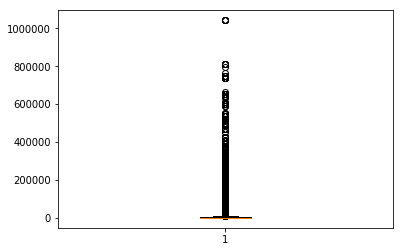

In [97]:
pyplot.boxplot(train_df.Reputation)

In [98]:
train_df[train_df.Reputation > 800000]

,Upvotes,Tag,Reputation,Views,Username,Answers
64572,5384.0,j,813314.0,15905.0,11382,4.0
70073,5316.0,j,813364.0,3899.0,11382,5.0
74699,2152.0,s,813374.0,1666.0,11382,1.0
111929,18862.0,c,809973.0,25908.0,22724,6.0
134390,1961.0,j,813314.0,2260.0,11382,1.0
160728,11844.0,c,1042428.0,14307.0,46604,4.0
163006,4414.0,c,1042428.0,5987.0,46604,4.0
206130,21675.0,c,1042428.0,22088.0,46604,5.0
236399,15453.0,c,1042428.0,17510.0,46604,11.0
263169,24119.0,c,1042428.0,26083.0,46604,10.0


{'boxes': [<matplotlib.lines.Line2D at 0x127a2e978>],
 'caps': [<matplotlib.lines.Line2D at 0x124c363c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x124c3d080>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x124c36c18>],
 'whiskers': [<matplotlib.lines.Line2D at 0x127a2eac8>,
  <matplotlib.lines.Line2D at 0x127a2ef60>]}

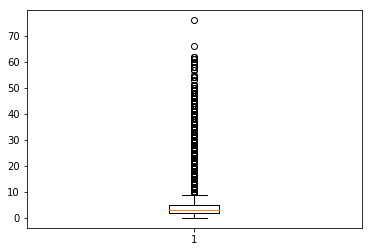

In [99]:
pyplot.boxplot(train_df.Answers)

In [100]:
train_df[train_df.Answers > 10].shape

(15434, 6)

{'boxes': [<matplotlib.lines.Line2D at 0x1276e4748>],
 'caps': [<matplotlib.lines.Line2D at 0x1276ea198>,
 'fliers': [<matplotlib.lines.Line2D at 0x1276eae10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1276ea9e8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1276e4898>,
  <matplotlib.lines.Line2D at 0x1276e4d30>]}

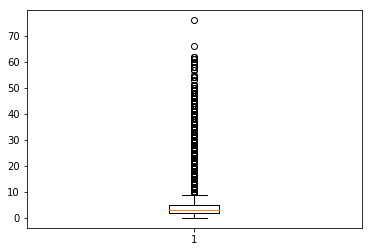

In [103]:
pyplot.boxplot(train_df.Answers)

(array([31695., 72458., 20564., 32400., 72232., 14546., 43407., 12442.,
        23323.,  6978.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

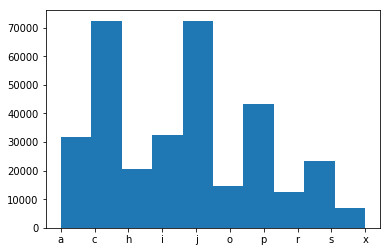

In [104]:
pyplot.hist(train_df.Tag)

{'boxes': [<matplotlib.lines.Line2D at 0x131a83e48>],
 'caps': [<matplotlib.lines.Line2D at 0x131a9e898>,
 'fliers': [<matplotlib.lines.Line2D at 0x131aa5550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x131aa5128>],
 'whiskers': [<matplotlib.lines.Line2D at 0x131a83f98>,
  <matplotlib.lines.Line2D at 0x131a9e470>]}

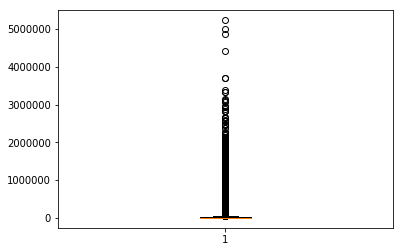

In [105]:
pyplot.boxplot(train_df.Views)

In [106]:
train_df[train_df.Views > 500000].shape

(1379, 6)

{'boxes': [<matplotlib.lines.Line2D at 0x1335f7be0>],
 'caps': [<matplotlib.lines.Line2D at 0x133602630>,
 'fliers': [<matplotlib.lines.Line2D at 0x1336082e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x133602e80>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1335f7d30>,
  <matplotlib.lines.Line2D at 0x133602208>]}

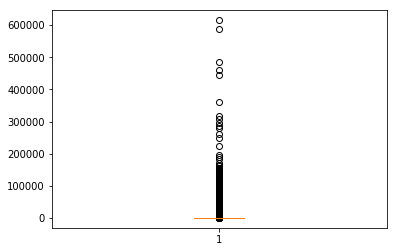

In [107]:
pyplot.boxplot(train_df.Upvotes)

In [108]:
train_df[train_df.Upvotes > train_df.Views].shape

(89, 6)

### Removing outliers

In [109]:
train_df = train_df[(train_df.Upvotes < train_df.Views) & (train_df.Views < 500000) &
                    (train_df.Upvotes < 300000) & (train_df.Answers < 10) & (train_df.Reputation < 800000)
                   ]

In [110]:
train_df.loc[train_df.Upvotes == 0, 'Upvotes'] = 0.01

train_df.Reputation = np.log(train_df.Reputation)
test_df.Reputation = np.log(test_df.Reputation)
train_df.Views = np.log(train_df.Views)
test_df.Views = np.log(test_df.Views)
train_df.Upvotes = np.log(train_df.Upvotes)

train_df['Tag'] = train_df['Tag'].astype('category')
train_df['Username'] = train_df['Username'].astype('category')
test_df['Tag'] = test_df['Tag'].astype('category')
test_df['Username'] = test_df['Username'].astype('category')

x = train_df[['Tag', 'Reputation', 'Answers', 'Username', 'Views']]
y = train_df['Upvotes']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=44)
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=[['Tag', 'Username']], free_raw_data=False)
eval_data = lgb.Dataset(x_test, label=y_test, categorical_feature=[['Tag', 'Username']], free_raw_data=False)

test_data = lgb.Dataset(test_df, categorical_feature=[['Tag', 'Username']], free_raw_data=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [111]:
model = lgb.LGBMRegressor(objective='regression',
                      early_stopping = 10, num_iteration=100, num_leaves=31)

In [112]:
model.fit(train_data.data, train_data.label, eval_set=[(eval_data.data, eval_data.label)],
         early_stopping_rounds=10, eval_metric='mean_squared_error')

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.01441
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 3.54503
[3]	valid_0's l2: 3.15968
[4]	valid_0's l2: 2.8442
[5]	valid_0's l2: 2.58508
[6]	valid_0's l2: 2.37168
[7]	valid_0's l2: 2.19741
[8]	valid_0's l2: 2.05301
[9]	valid_0's l2: 1.93526
[10]	valid_0's l2: 1.83826
[11]	valid_0's l2: 1.75781
[12]	valid_0's l2: 1.69029
[13]	valid_0's l2: 1.63516
[14]	valid_0's l2: 1.58945
[15]	valid_0's l2: 1.5519
[16]	valid_0's l2: 1.52041
[17]	valid_0's l2: 1.49442
[18]	valid_0's l2: 1.47245
[19]	valid_0's l2: 1.45426
[20]	valid_0's l2: 1.43927
[21]	valid_0's l2: 1.42667
[22]	valid_0's l2: 1.4163
[23]	valid_0's l2: 1.40764
[24]	valid_0's l2: 1.40021
[25]	valid_0's l2: 1.39407
[26]	valid_0's l2: 1.38888
[27]	valid_0's l2: 1.38427
[28]	valid_0's l2: 1.38053
[29]	valid_0's l2: 1.37734
[30]	valid_0's l2: 1.3747
[31]	valid_0's l2: 1.37215
[32]	valid_0's l2: 1.37022
[33]	valid_0's l2: 1.36846
[34]	valid_0's l2: 1.36716
[35]	valid_0's l2: 1.3659
[36]	va

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping=10, learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_iteration=100, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [128]:
param_grid = {
    'learning_rate': [0.9, 0.95],
    'bagging_fraction': [0.5, 0.75],
    'min_data_in_leaf': [20, 30], 
    'max_depth': [20, 25, 30], #40
    'num_leaves': [25, 30, 35], #35
    'n_estimators': [30, 40] #40
}

model_gs = GridSearchCV(model, param_grid)

In [ ]:
model_gs.fit(train_data.data, train_data.label, eval_set=[(test_data.data, test_data.label)], early_stopping_rounds=10, eval_metric='mean_squared_error')

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.34656
[5]	valid_0's l2: 4.19382
[6]	valid_0's l2: 4.18495
[7]	valid_0's l2: 4.22549
[8]	valid_0's l2: 4.19038
[9]	valid_0's l2: 4.28305
[10]	valid_0's l2: 4.28517
[11]	valid_0's l2: 4.29234
[12]	valid_0's l2: 4.29088
Early stopping, best iteration is:
[2]	valid_0's l2: 4.14234


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.65652
[5]	valid_0's l2: 4.64833
[6]	valid_0's l2: 4.58215
[7]	valid_0's l2: 4.15519
[8]	valid_0's l2: 4.23987
[9]	valid_0's l2: 4.27072
[10]	valid_0's l2: 4.59197
[11]	valid_0's l2: 4.56954
[12]	valid_0's l2: 4.57881
[13]	valid_0's l2: 4.59565
[14]	valid_0's l2: 4.68064
[15]	valid_0's l2: 4.98702
[16]	valid_0's l2: 4.98602
[17]	valid_0's l2: 4.96543
Early stopping, best iteration is:
[7]	valid_0's l2: 4.15519


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25352
[6]	valid_0's l2: 4.41912
[7]	valid_0's l2: 4.46303
[8]	valid_0's l2: 4.46259
[9]	valid_0's l2: 4.52362
[10]	valid_0's l2: 4.58428
[11]	valid_0's l2: 4.62575
[12]	valid_0's l2: 4.67141
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.38873
[6]	valid_0's l2: 4.40768
[7]	valid_0's l2: 4.43323
[8]	valid_0's l2: 4.73725
[9]	valid_0's l2: 4.71374
[10]	valid_0's l2: 4.69449
[11]	valid_0's l2: 4.76032
[12]	valid_0's l2: 4.77994
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.49115
[5]	valid_0's l2: 4.6405
[6]	valid_0's l2: 4.64848
[7]	valid_0's l2: 4.57868
[8]	valid_0's l2: 4.60452
[9]	valid_0's l2: 4.61919
[10]	valid_0's l2: 4.60207
[11]	valid_0's l2: 4.59855
[12]	valid_0's l2: 4.62084
[13]	valid_0's l2: 4.63741
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.50998
[7]	valid_0's l2: 4.53474
[8]	valid_0's l2: 4.41224
[9]	valid_0's l2: 4.41768
[10]	valid_0's l2: 4.43835
[11]	valid_0's l2: 4.42542
[12]	valid_0's l2: 4.43027
[13]	valid_0's l2: 4.43919
[14]	valid_0's l2: 4.42361
[15]	valid_0's l2: 4.41956
[16]	valid_0's l2: 4.45613
[17]	valid_0's l2: 4.45448
[18]	valid_0's l2: 4.48171
Early stopping, best iteration is:
[8]	valid_0's l2: 4.41224


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47354
[5]	valid_0's l2: 4.45803
[6]	valid_0's l2: 4.37992
[7]	valid_0's l2: 4.38092
[8]	valid_0's l2: 4.63681
[9]	valid_0's l2: 4.67853
[10]	valid_0's l2: 4.71361
[11]	valid_0's l2: 4.73663
[12]	valid_0's l2: 4.75391
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56727
[4]	valid_0's l2: 4.62751
[5]	valid_0's l2: 4.65949
[6]	valid_0's l2: 4.62444
[7]	valid_0's l2: 4.56656
[8]	valid_0's l2: 4.75687
[9]	valid_0's l2: 4.73429
[10]	valid_0's l2: 4.7365
[11]	valid_0's l2: 4.75674
[12]	valid_0's l2: 4.77309
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.41842
[5]	valid_0's l2: 4.51909
[6]	valid_0's l2: 4.48295
[7]	valid_0's l2: 4.96156
[8]	valid_0's l2: 4.99249
[9]	valid_0's l2: 4.94486
[10]	valid_0's l2: 4.95788
[11]	valid_0's l2: 4.93034
[12]	valid_0's l2: 4.94565
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.34656
[5]	valid_0's l2: 4.19382
[6]	valid_0's l2: 4.18495
[7]	valid_0's l2: 4.22549
[8]	valid_0's l2: 4.19038
[9]	valid_0's l2: 4.28305
[10]	valid_0's l2: 4.28517
[11]	valid_0's l2: 4.29234
[12]	valid_0's l2: 4.29088
Early stopping, best iteration is:
[2]	valid_0's l2: 4.14234


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.65652
[5]	valid_0's l2: 4.64833
[6]	valid_0's l2: 4.58215
[7]	valid_0's l2: 4.15519
[8]	valid_0's l2: 4.23987
[9]	valid_0's l2: 4.27072
[10]	valid_0's l2: 4.59197
[11]	valid_0's l2: 4.56954
[12]	valid_0's l2: 4.57881
[13]	valid_0's l2: 4.59565
[14]	valid_0's l2: 4.68064
[15]	valid_0's l2: 4.98702
[16]	valid_0's l2: 4.98602
[17]	valid_0's l2: 4.96543
Early stopping, best iteration is:
[7]	valid_0's l2: 4.15519


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25352
[6]	valid_0's l2: 4.41912
[7]	valid_0's l2: 4.46303
[8]	valid_0's l2: 4.46259
[9]	valid_0's l2: 4.52362
[10]	valid_0's l2: 4.58428
[11]	valid_0's l2: 4.62575
[12]	valid_0's l2: 4.67141
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.38873
[6]	valid_0's l2: 4.40768
[7]	valid_0's l2: 4.43323
[8]	valid_0's l2: 4.73725
[9]	valid_0's l2: 4.71374
[10]	valid_0's l2: 4.69449
[11]	valid_0's l2: 4.76032
[12]	valid_0's l2: 4.77994
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.49115
[5]	valid_0's l2: 4.6405
[6]	valid_0's l2: 4.64848
[7]	valid_0's l2: 4.57868
[8]	valid_0's l2: 4.60452
[9]	valid_0's l2: 4.61919
[10]	valid_0's l2: 4.60207
[11]	valid_0's l2: 4.59855
[12]	valid_0's l2: 4.62084
[13]	valid_0's l2: 4.63741
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.50998
[7]	valid_0's l2: 4.53474
[8]	valid_0's l2: 4.41224
[9]	valid_0's l2: 4.41768
[10]	valid_0's l2: 4.43835
[11]	valid_0's l2: 4.42542
[12]	valid_0's l2: 4.43027
[13]	valid_0's l2: 4.43919
[14]	valid_0's l2: 4.42361
[15]	valid_0's l2: 4.41956
[16]	valid_0's l2: 4.45613
[17]	valid_0's l2: 4.45448
[18]	valid_0's l2: 4.48171
Early stopping, best iteration is:
[8]	valid_0's l2: 4.41224


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47354
[5]	valid_0's l2: 4.45803
[6]	valid_0's l2: 4.37992
[7]	valid_0's l2: 4.38092
[8]	valid_0's l2: 4.63681
[9]	valid_0's l2: 4.67853
[10]	valid_0's l2: 4.71361
[11]	valid_0's l2: 4.73663
[12]	valid_0's l2: 4.75391
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56727
[4]	valid_0's l2: 4.62751
[5]	valid_0's l2: 4.65949
[6]	valid_0's l2: 4.62444
[7]	valid_0's l2: 4.56656
[8]	valid_0's l2: 4.75687
[9]	valid_0's l2: 4.73429
[10]	valid_0's l2: 4.7365
[11]	valid_0's l2: 4.75674
[12]	valid_0's l2: 4.77309
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.41842
[5]	valid_0's l2: 4.51909
[6]	valid_0's l2: 4.48295
[7]	valid_0's l2: 4.96156
[8]	valid_0's l2: 4.99249
[9]	valid_0's l2: 4.94486
[10]	valid_0's l2: 4.95788
[11]	valid_0's l2: 4.93034
[12]	valid_0's l2: 4.94565
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.35275
[5]	valid_0's l2: 4.11219
[6]	valid_0's l2: 4.1385
[7]	valid_0's l2: 4.26476
[8]	valid_0's l2: 4.31163
[9]	valid_0's l2: 4.30107
[10]	valid_0's l2: 4.28926
[11]	valid_0's l2: 4.31023
[12]	valid_0's l2: 4.32312
[13]	valid_0's l2: 4.32282
[14]	valid_0's l2: 4.31163
[15]	valid_0's l2: 4.31456
Early stopping, best iteration is:
[5]	valid_0's l2: 4.11219


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.64728
[5]	valid_0's l2: 4.40646
[6]	valid_0's l2: 4.37077
[7]	valid_0's l2: 4.36772
[8]	valid_0's l2: 4.41098
[9]	valid_0's l2: 4.44052
[10]	valid_0's l2: 4.45761
[11]	valid_0's l2: 4.45714
[12]	valid_0's l2: 4.45758
[13]	valid_0's l2: 4.56082
[14]	valid_0's l2: 4.56231
[15]	valid_0's l2: 4.56924
[16]	valid_0's l2: 4.51909
[17]	valid_0's l2: 4.5145
Early stopping, best iteration is:
[7]	valid_0's l2: 4.36772


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25249
[6]	valid_0's l2: 4.43286
[7]	valid_0's l2: 4.4519
[8]	valid_0's l2: 4.42594
[9]	valid_0's l2: 4.42946
[10]	valid_0's l2: 4.43354
[11]	valid_0's l2: 4.47516
[12]	valid_0's l2: 4.49978
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.39296
[6]	valid_0's l2: 4.4079
[7]	valid_0's l2: 4.4441
[8]	valid_0's l2: 4.51679
[9]	valid_0's l2: 4.57296
[10]	valid_0's l2: 4.55447
[11]	valid_0's l2: 4.56173
[12]	valid_0's l2: 4.60158
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.48609
[5]	valid_0's l2: 4.63245
[6]	valid_0's l2: 4.60782
[7]	valid_0's l2: 4.5886
[8]	valid_0's l2: 4.63318
[9]	valid_0's l2: 4.64134
[10]	valid_0's l2: 4.54811
[11]	valid_0's l2: 4.5842
[12]	valid_0's l2: 4.59141
[13]	valid_0's l2: 4.65262
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.49777
[7]	valid_0's l2: 4.51059
[8]	valid_0's l2: 4.3793
[9]	valid_0's l2: 4.2657
[10]	valid_0's l2: 4.34265
[11]	valid_0's l2: 4.36718
[12]	valid_0's l2: 4.40724
[13]	valid_0's l2: 4.455
[14]	valid_0's l2: 4.4501
[15]	valid_0's l2: 4.65882
[16]	valid_0's l2: 4.63648
[17]	valid_0's l2: 4.58257
[18]	valid_0's l2: 4.60759
[19]	valid_0's l2: 4.59247
Early stopping, best iteration is:
[9]	valid_0's l2: 4.2657


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47333
[5]	valid_0's l2: 4.5695
[6]	valid_0's l2: 4.5946
[7]	valid_0's l2: 4.53758
[8]	valid_0's l2: 4.55077
[9]	valid_0's l2: 4.57149
[10]	valid_0's l2: 4.54329
[11]	valid_0's l2: 4.54135
[12]	valid_0's l2: 4.55467
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56426
[4]	valid_0's l2: 4.62961
[5]	valid_0's l2: 4.6787
[6]	valid_0's l2: 4.76735
[7]	valid_0's l2: 4.77508
[8]	valid_0's l2: 4.69231
[9]	valid_0's l2: 4.69448
[10]	valid_0's l2: 4.70251
[11]	valid_0's l2: 5.04488
[12]	valid_0's l2: 5.04051
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.4377
[5]	valid_0's l2: 4.49766
[6]	valid_0's l2: 4.47248
[7]	valid_0's l2: 4.36588
[8]	valid_0's l2: 4.46096
[9]	valid_0's l2: 4.67906
[10]	valid_0's l2: 4.73633
[11]	valid_0's l2: 4.6115
[12]	valid_0's l2: 4.61537
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.35275
[5]	valid_0's l2: 4.11219
[6]	valid_0's l2: 4.1385
[7]	valid_0's l2: 4.26476
[8]	valid_0's l2: 4.31163
[9]	valid_0's l2: 4.30107
[10]	valid_0's l2: 4.28926
[11]	valid_0's l2: 4.31023
[12]	valid_0's l2: 4.32312
[13]	valid_0's l2: 4.32282
[14]	valid_0's l2: 4.31163
[15]	valid_0's l2: 4.31456
Early stopping, best iteration is:
[5]	valid_0's l2: 4.11219


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.64728
[5]	valid_0's l2: 4.40646
[6]	valid_0's l2: 4.37077
[7]	valid_0's l2: 4.36772
[8]	valid_0's l2: 4.41098
[9]	valid_0's l2: 4.44052
[10]	valid_0's l2: 4.45761
[11]	valid_0's l2: 4.45714
[12]	valid_0's l2: 4.45758
[13]	valid_0's l2: 4.56082
[14]	valid_0's l2: 4.56231
[15]	valid_0's l2: 4.56924
[16]	valid_0's l2: 4.51909
[17]	valid_0's l2: 4.5145
Early stopping, best iteration is:
[7]	valid_0's l2: 4.36772


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25249
[6]	valid_0's l2: 4.43286
[7]	valid_0's l2: 4.4519
[8]	valid_0's l2: 4.42594
[9]	valid_0's l2: 4.42946
[10]	valid_0's l2: 4.43354
[11]	valid_0's l2: 4.47516
[12]	valid_0's l2: 4.49978
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.39296
[6]	valid_0's l2: 4.4079
[7]	valid_0's l2: 4.4441
[8]	valid_0's l2: 4.51679
[9]	valid_0's l2: 4.57296
[10]	valid_0's l2: 4.55447
[11]	valid_0's l2: 4.56173
[12]	valid_0's l2: 4.60158
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.48609
[5]	valid_0's l2: 4.63245
[6]	valid_0's l2: 4.60782
[7]	valid_0's l2: 4.5886
[8]	valid_0's l2: 4.63318
[9]	valid_0's l2: 4.64134
[10]	valid_0's l2: 4.54811
[11]	valid_0's l2: 4.5842
[12]	valid_0's l2: 4.59141
[13]	valid_0's l2: 4.65262
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.49777
[7]	valid_0's l2: 4.51059
[8]	valid_0's l2: 4.3793
[9]	valid_0's l2: 4.2657
[10]	valid_0's l2: 4.34265
[11]	valid_0's l2: 4.36718
[12]	valid_0's l2: 4.40724
[13]	valid_0's l2: 4.455
[14]	valid_0's l2: 4.4501
[15]	valid_0's l2: 4.65882
[16]	valid_0's l2: 4.63648
[17]	valid_0's l2: 4.58257
[18]	valid_0's l2: 4.60759
[19]	valid_0's l2: 4.59247
Early stopping, best iteration is:
[9]	valid_0's l2: 4.2657


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47333
[5]	valid_0's l2: 4.5695
[6]	valid_0's l2: 4.5946
[7]	valid_0's l2: 4.53758
[8]	valid_0's l2: 4.55077
[9]	valid_0's l2: 4.57149
[10]	valid_0's l2: 4.54329
[11]	valid_0's l2: 4.54135
[12]	valid_0's l2: 4.55467
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56426
[4]	valid_0's l2: 4.62961
[5]	valid_0's l2: 4.6787
[6]	valid_0's l2: 4.76735
[7]	valid_0's l2: 4.77508
[8]	valid_0's l2: 4.69231
[9]	valid_0's l2: 4.69448
[10]	valid_0's l2: 4.70251
[11]	valid_0's l2: 5.04488
[12]	valid_0's l2: 5.04051
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.4377
[5]	valid_0's l2: 4.49766
[6]	valid_0's l2: 4.47248
[7]	valid_0's l2: 4.36588
[8]	valid_0's l2: 4.46096
[9]	valid_0's l2: 4.67906
[10]	valid_0's l2: 4.73633
[11]	valid_0's l2: 4.6115
[12]	valid_0's l2: 4.61537
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.34656
[5]	valid_0's l2: 4.19382
[6]	valid_0's l2: 4.18495
[7]	valid_0's l2: 4.22549
[8]	valid_0's l2: 4.19038
[9]	valid_0's l2: 4.28305
[10]	valid_0's l2: 4.28517
[11]	valid_0's l2: 4.29234
[12]	valid_0's l2: 4.29088
Early stopping, best iteration is:
[2]	valid_0's l2: 4.14234


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.65652
[5]	valid_0's l2: 4.64833
[6]	valid_0's l2: 4.58215
[7]	valid_0's l2: 4.15519
[8]	valid_0's l2: 4.23987
[9]	valid_0's l2: 4.27072
[10]	valid_0's l2: 4.59197
[11]	valid_0's l2: 4.56954
[12]	valid_0's l2: 4.57881
[13]	valid_0's l2: 4.59565
[14]	valid_0's l2: 4.68064
[15]	valid_0's l2: 4.98702
[16]	valid_0's l2: 4.98602
[17]	valid_0's l2: 4.96543
Early stopping, best iteration is:
[7]	valid_0's l2: 4.15519


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25352
[6]	valid_0's l2: 4.41912
[7]	valid_0's l2: 4.46303
[8]	valid_0's l2: 4.46259
[9]	valid_0's l2: 4.52362
[10]	valid_0's l2: 4.58428
[11]	valid_0's l2: 4.62575
[12]	valid_0's l2: 4.67141
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.38873
[6]	valid_0's l2: 4.40768
[7]	valid_0's l2: 4.43323
[8]	valid_0's l2: 4.73725
[9]	valid_0's l2: 4.71374
[10]	valid_0's l2: 4.69449
[11]	valid_0's l2: 4.76032
[12]	valid_0's l2: 4.77994
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.49115
[5]	valid_0's l2: 4.6405
[6]	valid_0's l2: 4.64848
[7]	valid_0's l2: 4.57868
[8]	valid_0's l2: 4.60452
[9]	valid_0's l2: 4.61919
[10]	valid_0's l2: 4.60207
[11]	valid_0's l2: 4.59855
[12]	valid_0's l2: 4.62084
[13]	valid_0's l2: 4.63741
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.50998
[7]	valid_0's l2: 4.53474
[8]	valid_0's l2: 4.41224
[9]	valid_0's l2: 4.41768
[10]	valid_0's l2: 4.43835
[11]	valid_0's l2: 4.42542
[12]	valid_0's l2: 4.43027
[13]	valid_0's l2: 4.43919
[14]	valid_0's l2: 4.42361
[15]	valid_0's l2: 4.41956
[16]	valid_0's l2: 4.45613
[17]	valid_0's l2: 4.45448
[18]	valid_0's l2: 4.48171
Early stopping, best iteration is:
[8]	valid_0's l2: 4.41224


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47354
[5]	valid_0's l2: 4.45803
[6]	valid_0's l2: 4.37992
[7]	valid_0's l2: 4.38092
[8]	valid_0's l2: 4.63681
[9]	valid_0's l2: 4.67853
[10]	valid_0's l2: 4.71361
[11]	valid_0's l2: 4.73663
[12]	valid_0's l2: 4.75391
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56727
[4]	valid_0's l2: 4.62751
[5]	valid_0's l2: 4.65949
[6]	valid_0's l2: 4.62444
[7]	valid_0's l2: 4.56656
[8]	valid_0's l2: 4.75687
[9]	valid_0's l2: 4.73429
[10]	valid_0's l2: 4.7365
[11]	valid_0's l2: 4.75674
[12]	valid_0's l2: 4.77309
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.41842
[5]	valid_0's l2: 4.51909
[6]	valid_0's l2: 4.48295
[7]	valid_0's l2: 4.96156
[8]	valid_0's l2: 4.99249
[9]	valid_0's l2: 4.94486
[10]	valid_0's l2: 4.95788
[11]	valid_0's l2: 4.93034
[12]	valid_0's l2: 4.94565
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.34656
[5]	valid_0's l2: 4.19382
[6]	valid_0's l2: 4.18495
[7]	valid_0's l2: 4.22549
[8]	valid_0's l2: 4.19038
[9]	valid_0's l2: 4.28305
[10]	valid_0's l2: 4.28517
[11]	valid_0's l2: 4.29234
[12]	valid_0's l2: 4.29088
Early stopping, best iteration is:
[2]	valid_0's l2: 4.14234


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.65652
[5]	valid_0's l2: 4.64833
[6]	valid_0's l2: 4.58215
[7]	valid_0's l2: 4.15519
[8]	valid_0's l2: 4.23987
[9]	valid_0's l2: 4.27072
[10]	valid_0's l2: 4.59197
[11]	valid_0's l2: 4.56954
[12]	valid_0's l2: 4.57881
[13]	valid_0's l2: 4.59565
[14]	valid_0's l2: 4.68064
[15]	valid_0's l2: 4.98702
[16]	valid_0's l2: 4.98602
[17]	valid_0's l2: 4.96543
Early stopping, best iteration is:
[7]	valid_0's l2: 4.15519


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25352
[6]	valid_0's l2: 4.41912
[7]	valid_0's l2: 4.46303
[8]	valid_0's l2: 4.46259
[9]	valid_0's l2: 4.52362
[10]	valid_0's l2: 4.58428
[11]	valid_0's l2: 4.62575
[12]	valid_0's l2: 4.67141
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.38873
[6]	valid_0's l2: 4.40768
[7]	valid_0's l2: 4.43323
[8]	valid_0's l2: 4.73725
[9]	valid_0's l2: 4.71374
[10]	valid_0's l2: 4.69449
[11]	valid_0's l2: 4.76032
[12]	valid_0's l2: 4.77994
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.49115
[5]	valid_0's l2: 4.6405
[6]	valid_0's l2: 4.64848
[7]	valid_0's l2: 4.57868
[8]	valid_0's l2: 4.60452
[9]	valid_0's l2: 4.61919
[10]	valid_0's l2: 4.60207
[11]	valid_0's l2: 4.59855
[12]	valid_0's l2: 4.62084
[13]	valid_0's l2: 4.63741
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.50998
[7]	valid_0's l2: 4.53474
[8]	valid_0's l2: 4.41224
[9]	valid_0's l2: 4.41768
[10]	valid_0's l2: 4.43835
[11]	valid_0's l2: 4.42542
[12]	valid_0's l2: 4.43027
[13]	valid_0's l2: 4.43919
[14]	valid_0's l2: 4.42361
[15]	valid_0's l2: 4.41956
[16]	valid_0's l2: 4.45613
[17]	valid_0's l2: 4.45448
[18]	valid_0's l2: 4.48171
Early stopping, best iteration is:
[8]	valid_0's l2: 4.41224


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47354
[5]	valid_0's l2: 4.45803
[6]	valid_0's l2: 4.37992
[7]	valid_0's l2: 4.38092
[8]	valid_0's l2: 4.63681
[9]	valid_0's l2: 4.67853
[10]	valid_0's l2: 4.71361
[11]	valid_0's l2: 4.73663
[12]	valid_0's l2: 4.75391
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56727
[4]	valid_0's l2: 4.62751
[5]	valid_0's l2: 4.65949
[6]	valid_0's l2: 4.62444
[7]	valid_0's l2: 4.56656
[8]	valid_0's l2: 4.75687
[9]	valid_0's l2: 4.73429
[10]	valid_0's l2: 4.7365
[11]	valid_0's l2: 4.75674
[12]	valid_0's l2: 4.77309
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.41842
[5]	valid_0's l2: 4.51909
[6]	valid_0's l2: 4.48295
[7]	valid_0's l2: 4.96156
[8]	valid_0's l2: 4.99249
[9]	valid_0's l2: 4.94486
[10]	valid_0's l2: 4.95788
[11]	valid_0's l2: 4.93034
[12]	valid_0's l2: 4.94565
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.35275
[5]	valid_0's l2: 4.11219
[6]	valid_0's l2: 4.1385
[7]	valid_0's l2: 4.26476
[8]	valid_0's l2: 4.31163
[9]	valid_0's l2: 4.30107
[10]	valid_0's l2: 4.28926
[11]	valid_0's l2: 4.31023
[12]	valid_0's l2: 4.32312
[13]	valid_0's l2: 4.32282
[14]	valid_0's l2: 4.31163
[15]	valid_0's l2: 4.31456
Early stopping, best iteration is:
[5]	valid_0's l2: 4.11219


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.64728
[5]	valid_0's l2: 4.40646
[6]	valid_0's l2: 4.37077
[7]	valid_0's l2: 4.36772
[8]	valid_0's l2: 4.41098
[9]	valid_0's l2: 4.44052
[10]	valid_0's l2: 4.45761
[11]	valid_0's l2: 4.45714
[12]	valid_0's l2: 4.45758
[13]	valid_0's l2: 4.56082
[14]	valid_0's l2: 4.56231
[15]	valid_0's l2: 4.56924
[16]	valid_0's l2: 4.51909
[17]	valid_0's l2: 4.5145
Early stopping, best iteration is:
[7]	valid_0's l2: 4.36772


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25249
[6]	valid_0's l2: 4.43286
[7]	valid_0's l2: 4.4519
[8]	valid_0's l2: 4.42594
[9]	valid_0's l2: 4.42946
[10]	valid_0's l2: 4.43354
[11]	valid_0's l2: 4.47516
[12]	valid_0's l2: 4.49978
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.39296
[6]	valid_0's l2: 4.4079
[7]	valid_0's l2: 4.4441
[8]	valid_0's l2: 4.51679
[9]	valid_0's l2: 4.57296
[10]	valid_0's l2: 4.55447
[11]	valid_0's l2: 4.56173
[12]	valid_0's l2: 4.60158
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.48609
[5]	valid_0's l2: 4.63245
[6]	valid_0's l2: 4.60782
[7]	valid_0's l2: 4.5886
[8]	valid_0's l2: 4.63318
[9]	valid_0's l2: 4.64134
[10]	valid_0's l2: 4.54811
[11]	valid_0's l2: 4.5842
[12]	valid_0's l2: 4.59141
[13]	valid_0's l2: 4.65262
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.49777
[7]	valid_0's l2: 4.51059
[8]	valid_0's l2: 4.3793
[9]	valid_0's l2: 4.2657
[10]	valid_0's l2: 4.34265
[11]	valid_0's l2: 4.36718
[12]	valid_0's l2: 4.40724
[13]	valid_0's l2: 4.455
[14]	valid_0's l2: 4.4501
[15]	valid_0's l2: 4.65882
[16]	valid_0's l2: 4.63648
[17]	valid_0's l2: 4.58257
[18]	valid_0's l2: 4.60759
[19]	valid_0's l2: 4.59247
Early stopping, best iteration is:
[9]	valid_0's l2: 4.2657


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47333
[5]	valid_0's l2: 4.5695
[6]	valid_0's l2: 4.5946
[7]	valid_0's l2: 4.53758
[8]	valid_0's l2: 4.55077
[9]	valid_0's l2: 4.57149
[10]	valid_0's l2: 4.54329
[11]	valid_0's l2: 4.54135
[12]	valid_0's l2: 4.55467
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56426
[4]	valid_0's l2: 4.62962
[5]	valid_0's l2: 4.67983
[6]	valid_0's l2: 4.63497
[7]	valid_0's l2: 4.66232
[8]	valid_0's l2: 4.6798
[9]	valid_0's l2: 5.00761
[10]	valid_0's l2: 5.00587
[11]	valid_0's l2: 5.12274
[12]	valid_0's l2: 5.10739
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.4377
[5]	valid_0's l2: 4.49766
[6]	valid_0's l2: 4.47248
[7]	valid_0's l2: 4.36588
[8]	valid_0's l2: 4.46096
[9]	valid_0's l2: 4.67906
[10]	valid_0's l2: 4.73633
[11]	valid_0's l2: 4.6115
[12]	valid_0's l2: 4.61537
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.35275
[5]	valid_0's l2: 4.11219
[6]	valid_0's l2: 4.1385
[7]	valid_0's l2: 4.26476
[8]	valid_0's l2: 4.31163
[9]	valid_0's l2: 4.30107
[10]	valid_0's l2: 4.28926
[11]	valid_0's l2: 4.31023
[12]	valid_0's l2: 4.32312
[13]	valid_0's l2: 4.32282
[14]	valid_0's l2: 4.31163
[15]	valid_0's l2: 4.31456
Early stopping, best iteration is:
[5]	valid_0's l2: 4.11219


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.64728
[5]	valid_0's l2: 4.40646
[6]	valid_0's l2: 4.37077
[7]	valid_0's l2: 4.36772
[8]	valid_0's l2: 4.41098
[9]	valid_0's l2: 4.44052
[10]	valid_0's l2: 4.45761
[11]	valid_0's l2: 4.45714
[12]	valid_0's l2: 4.45758
[13]	valid_0's l2: 4.56082
[14]	valid_0's l2: 4.56231
[15]	valid_0's l2: 4.56924
[16]	valid_0's l2: 4.51909
[17]	valid_0's l2: 4.5145
Early stopping, best iteration is:
[7]	valid_0's l2: 4.36772


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25249
[6]	valid_0's l2: 4.43286
[7]	valid_0's l2: 4.4519
[8]	valid_0's l2: 4.42594
[9]	valid_0's l2: 4.42946
[10]	valid_0's l2: 4.43354
[11]	valid_0's l2: 4.47516
[12]	valid_0's l2: 4.49978
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.39296
[6]	valid_0's l2: 4.4079
[7]	valid_0's l2: 4.4441
[8]	valid_0's l2: 4.51679
[9]	valid_0's l2: 4.57296
[10]	valid_0's l2: 4.55447
[11]	valid_0's l2: 4.56173
[12]	valid_0's l2: 4.60158
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.48609
[5]	valid_0's l2: 4.63245
[6]	valid_0's l2: 4.60782
[7]	valid_0's l2: 4.5886
[8]	valid_0's l2: 4.63318
[9]	valid_0's l2: 4.64134
[10]	valid_0's l2: 4.54811
[11]	valid_0's l2: 4.5842
[12]	valid_0's l2: 4.59141
[13]	valid_0's l2: 4.65262
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.49777
[7]	valid_0's l2: 4.51059
[8]	valid_0's l2: 4.3793
[9]	valid_0's l2: 4.2657
[10]	valid_0's l2: 4.34265
[11]	valid_0's l2: 4.36718
[12]	valid_0's l2: 4.40724
[13]	valid_0's l2: 4.455
[14]	valid_0's l2: 4.4501
[15]	valid_0's l2: 4.65882
[16]	valid_0's l2: 4.63648
[17]	valid_0's l2: 4.58257
[18]	valid_0's l2: 4.60759
[19]	valid_0's l2: 4.59247
Early stopping, best iteration is:
[9]	valid_0's l2: 4.2657


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47333
[5]	valid_0's l2: 4.5695
[6]	valid_0's l2: 4.5946
[7]	valid_0's l2: 4.53758
[8]	valid_0's l2: 4.55077
[9]	valid_0's l2: 4.57149
[10]	valid_0's l2: 4.54329
[11]	valid_0's l2: 4.54135
[12]	valid_0's l2: 4.55467
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56426
[4]	valid_0's l2: 4.62962
[5]	valid_0's l2: 4.67983
[6]	valid_0's l2: 4.63497
[7]	valid_0's l2: 4.66232
[8]	valid_0's l2: 4.6798
[9]	valid_0's l2: 5.00761
[10]	valid_0's l2: 5.00587
[11]	valid_0's l2: 5.12274
[12]	valid_0's l2: 5.10739
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.4377
[5]	valid_0's l2: 4.49766
[6]	valid_0's l2: 4.47248
[7]	valid_0's l2: 4.36588
[8]	valid_0's l2: 4.46096
[9]	valid_0's l2: 4.67906
[10]	valid_0's l2: 4.73633
[11]	valid_0's l2: 4.6115
[12]	valid_0's l2: 4.61537
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.34656
[5]	valid_0's l2: 4.19382
[6]	valid_0's l2: 4.18495
[7]	valid_0's l2: 4.22549
[8]	valid_0's l2: 4.19038
[9]	valid_0's l2: 4.28305
[10]	valid_0's l2: 4.28517
[11]	valid_0's l2: 4.29234
[12]	valid_0's l2: 4.29088
Early stopping, best iteration is:
[2]	valid_0's l2: 4.14234


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.65652
[5]	valid_0's l2: 4.64833
[6]	valid_0's l2: 4.58215
[7]	valid_0's l2: 4.15519
[8]	valid_0's l2: 4.23987
[9]	valid_0's l2: 4.27072
[10]	valid_0's l2: 4.59197
[11]	valid_0's l2: 4.56954
[12]	valid_0's l2: 4.57881
[13]	valid_0's l2: 4.59565
[14]	valid_0's l2: 4.68064
[15]	valid_0's l2: 4.98702
[16]	valid_0's l2: 4.98602
[17]	valid_0's l2: 4.96543
Early stopping, best iteration is:
[7]	valid_0's l2: 4.15519


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25352
[6]	valid_0's l2: 4.41912
[7]	valid_0's l2: 4.46303
[8]	valid_0's l2: 4.46259
[9]	valid_0's l2: 4.52362
[10]	valid_0's l2: 4.58428
[11]	valid_0's l2: 4.62575
[12]	valid_0's l2: 4.67141
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.38873
[6]	valid_0's l2: 4.40768
[7]	valid_0's l2: 4.43323
[8]	valid_0's l2: 4.73725
[9]	valid_0's l2: 4.71374
[10]	valid_0's l2: 4.69449
[11]	valid_0's l2: 4.76032
[12]	valid_0's l2: 4.77994
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.49115
[5]	valid_0's l2: 4.6405
[6]	valid_0's l2: 4.64848
[7]	valid_0's l2: 4.57868
[8]	valid_0's l2: 4.60452
[9]	valid_0's l2: 4.61919
[10]	valid_0's l2: 4.60207
[11]	valid_0's l2: 4.59855
[12]	valid_0's l2: 4.62084
[13]	valid_0's l2: 4.63741
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.50998
[7]	valid_0's l2: 4.53474
[8]	valid_0's l2: 4.41224
[9]	valid_0's l2: 4.41768
[10]	valid_0's l2: 4.43835
[11]	valid_0's l2: 4.42542
[12]	valid_0's l2: 4.43027
[13]	valid_0's l2: 4.43919
[14]	valid_0's l2: 4.42361
[15]	valid_0's l2: 4.41956
[16]	valid_0's l2: 4.45613
[17]	valid_0's l2: 4.45448
[18]	valid_0's l2: 4.48171
Early stopping, best iteration is:
[8]	valid_0's l2: 4.41224


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47354
[5]	valid_0's l2: 4.45803
[6]	valid_0's l2: 4.37992
[7]	valid_0's l2: 4.38092
[8]	valid_0's l2: 4.63681
[9]	valid_0's l2: 4.67853
[10]	valid_0's l2: 4.71361
[11]	valid_0's l2: 4.73663
[12]	valid_0's l2: 4.75391
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56727
[4]	valid_0's l2: 4.62751
[5]	valid_0's l2: 4.65949
[6]	valid_0's l2: 4.62444
[7]	valid_0's l2: 4.56656
[8]	valid_0's l2: 4.75687
[9]	valid_0's l2: 4.73429
[10]	valid_0's l2: 4.7365
[11]	valid_0's l2: 4.75674
[12]	valid_0's l2: 4.77309
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.41842
[5]	valid_0's l2: 4.51909
[6]	valid_0's l2: 4.48295
[7]	valid_0's l2: 4.96156
[8]	valid_0's l2: 4.99249
[9]	valid_0's l2: 4.94486
[10]	valid_0's l2: 4.95788
[11]	valid_0's l2: 4.93034
[12]	valid_0's l2: 4.94565
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.34656
[5]	valid_0's l2: 4.19382
[6]	valid_0's l2: 4.18495
[7]	valid_0's l2: 4.22549
[8]	valid_0's l2: 4.19038
[9]	valid_0's l2: 4.28305
[10]	valid_0's l2: 4.28517
[11]	valid_0's l2: 4.29234
[12]	valid_0's l2: 4.29088
Early stopping, best iteration is:
[2]	valid_0's l2: 4.14234


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.65652
[5]	valid_0's l2: 4.64833
[6]	valid_0's l2: 4.58215
[7]	valid_0's l2: 4.15519
[8]	valid_0's l2: 4.23987
[9]	valid_0's l2: 4.27072
[10]	valid_0's l2: 4.59197
[11]	valid_0's l2: 4.56954
[12]	valid_0's l2: 4.57881
[13]	valid_0's l2: 4.59565
[14]	valid_0's l2: 4.68064
[15]	valid_0's l2: 4.98702
[16]	valid_0's l2: 4.98602
[17]	valid_0's l2: 4.96543
Early stopping, best iteration is:
[7]	valid_0's l2: 4.15519


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25352
[6]	valid_0's l2: 4.41912
[7]	valid_0's l2: 4.46303
[8]	valid_0's l2: 4.46259
[9]	valid_0's l2: 4.52362
[10]	valid_0's l2: 4.58428
[11]	valid_0's l2: 4.62575
[12]	valid_0's l2: 4.67141
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.38873
[6]	valid_0's l2: 4.40768
[7]	valid_0's l2: 4.43323
[8]	valid_0's l2: 4.73725
[9]	valid_0's l2: 4.71374
[10]	valid_0's l2: 4.69449
[11]	valid_0's l2: 4.76032
[12]	valid_0's l2: 4.77994
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.49115
[5]	valid_0's l2: 4.6405
[6]	valid_0's l2: 4.64848
[7]	valid_0's l2: 4.57868
[8]	valid_0's l2: 4.60452
[9]	valid_0's l2: 4.61919
[10]	valid_0's l2: 4.60207
[11]	valid_0's l2: 4.59855
[12]	valid_0's l2: 4.62084
[13]	valid_0's l2: 4.63741
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.50998
[7]	valid_0's l2: 4.53474
[8]	valid_0's l2: 4.41224
[9]	valid_0's l2: 4.41768
[10]	valid_0's l2: 4.43835
[11]	valid_0's l2: 4.42542
[12]	valid_0's l2: 4.43027
[13]	valid_0's l2: 4.43919
[14]	valid_0's l2: 4.42361
[15]	valid_0's l2: 4.41956
[16]	valid_0's l2: 4.45613
[17]	valid_0's l2: 4.45448
[18]	valid_0's l2: 4.48171
Early stopping, best iteration is:
[8]	valid_0's l2: 4.41224


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47354
[5]	valid_0's l2: 4.45803
[6]	valid_0's l2: 4.37992
[7]	valid_0's l2: 4.38092
[8]	valid_0's l2: 4.63681
[9]	valid_0's l2: 4.67853
[10]	valid_0's l2: 4.71361
[11]	valid_0's l2: 4.73663
[12]	valid_0's l2: 4.75391
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56727
[4]	valid_0's l2: 4.62751
[5]	valid_0's l2: 4.65949
[6]	valid_0's l2: 4.62444
[7]	valid_0's l2: 4.56656
[8]	valid_0's l2: 4.75687
[9]	valid_0's l2: 4.73429
[10]	valid_0's l2: 4.7365
[11]	valid_0's l2: 4.75674
[12]	valid_0's l2: 4.77309
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.41842
[5]	valid_0's l2: 4.51909
[6]	valid_0's l2: 4.48295
[7]	valid_0's l2: 4.96156
[8]	valid_0's l2: 4.99249
[9]	valid_0's l2: 4.94486
[10]	valid_0's l2: 4.95788
[11]	valid_0's l2: 4.93034
[12]	valid_0's l2: 4.94565
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.35275
[5]	valid_0's l2: 4.11219
[6]	valid_0's l2: 4.1385
[7]	valid_0's l2: 4.26476
[8]	valid_0's l2: 4.31163
[9]	valid_0's l2: 4.30107
[10]	valid_0's l2: 4.28926
[11]	valid_0's l2: 4.31023
[12]	valid_0's l2: 4.32312
[13]	valid_0's l2: 4.32282
[14]	valid_0's l2: 4.31163
[15]	valid_0's l2: 4.31456
Early stopping, best iteration is:
[5]	valid_0's l2: 4.11219


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.64728
[5]	valid_0's l2: 4.40646
[6]	valid_0's l2: 4.37077
[7]	valid_0's l2: 4.36772
[8]	valid_0's l2: 4.41098
[9]	valid_0's l2: 4.44052
[10]	valid_0's l2: 4.45761
[11]	valid_0's l2: 4.45714
[12]	valid_0's l2: 4.45758
[13]	valid_0's l2: 4.56082
[14]	valid_0's l2: 4.56231
[15]	valid_0's l2: 4.56924
[16]	valid_0's l2: 4.51909
[17]	valid_0's l2: 4.5145
Early stopping, best iteration is:
[7]	valid_0's l2: 4.36772


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25249
[6]	valid_0's l2: 4.43286
[7]	valid_0's l2: 4.4519
[8]	valid_0's l2: 4.42594
[9]	valid_0's l2: 4.42946
[10]	valid_0's l2: 4.43354
[11]	valid_0's l2: 4.47516
[12]	valid_0's l2: 4.49978
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.39296
[6]	valid_0's l2: 4.4079
[7]	valid_0's l2: 4.4441
[8]	valid_0's l2: 4.51679
[9]	valid_0's l2: 4.57296
[10]	valid_0's l2: 4.55447
[11]	valid_0's l2: 4.56173
[12]	valid_0's l2: 4.60158
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.48609
[5]	valid_0's l2: 4.63245
[6]	valid_0's l2: 4.60782
[7]	valid_0's l2: 4.5886
[8]	valid_0's l2: 4.63318
[9]	valid_0's l2: 4.64134
[10]	valid_0's l2: 4.54811
[11]	valid_0's l2: 4.5842
[12]	valid_0's l2: 4.59141
[13]	valid_0's l2: 4.65262
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.49777
[7]	valid_0's l2: 4.51059
[8]	valid_0's l2: 4.3793
[9]	valid_0's l2: 4.2657
[10]	valid_0's l2: 4.34265
[11]	valid_0's l2: 4.36718
[12]	valid_0's l2: 4.40724
[13]	valid_0's l2: 4.455
[14]	valid_0's l2: 4.4501
[15]	valid_0's l2: 4.65882
[16]	valid_0's l2: 4.63648
[17]	valid_0's l2: 4.58257
[18]	valid_0's l2: 4.60759
[19]	valid_0's l2: 4.59247
Early stopping, best iteration is:
[9]	valid_0's l2: 4.2657


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47333
[5]	valid_0's l2: 4.5695
[6]	valid_0's l2: 4.5946
[7]	valid_0's l2: 4.53758
[8]	valid_0's l2: 4.55077
[9]	valid_0's l2: 4.57149
[10]	valid_0's l2: 4.54329
[11]	valid_0's l2: 4.54135
[12]	valid_0's l2: 4.55467
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56426
[4]	valid_0's l2: 4.62962
[5]	valid_0's l2: 4.67983
[6]	valid_0's l2: 4.63497
[7]	valid_0's l2: 4.66232
[8]	valid_0's l2: 4.6798
[9]	valid_0's l2: 5.00761
[10]	valid_0's l2: 5.00587
[11]	valid_0's l2: 5.12274
[12]	valid_0's l2: 5.10739
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.4377
[5]	valid_0's l2: 4.49766
[6]	valid_0's l2: 4.47248
[7]	valid_0's l2: 4.36588
[8]	valid_0's l2: 4.46096
[9]	valid_0's l2: 4.67906
[10]	valid_0's l2: 4.73633
[11]	valid_0's l2: 4.6115
[12]	valid_0's l2: 4.61537
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.42374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.14234
[3]	valid_0's l2: 4.29621
[4]	valid_0's l2: 4.35275
[5]	valid_0's l2: 4.11219
[6]	valid_0's l2: 4.1385
[7]	valid_0's l2: 4.26476
[8]	valid_0's l2: 4.31163
[9]	valid_0's l2: 4.30107
[10]	valid_0's l2: 4.28926
[11]	valid_0's l2: 4.31023
[12]	valid_0's l2: 4.32312
[13]	valid_0's l2: 4.32282
[14]	valid_0's l2: 4.31163
[15]	valid_0's l2: 4.31456
Early stopping, best iteration is:
[5]	valid_0's l2: 4.11219


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5125
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53866
[3]	valid_0's l2: 4.43287
[4]	valid_0's l2: 4.64728
[5]	valid_0's l2: 4.40646
[6]	valid_0's l2: 4.37077
[7]	valid_0's l2: 4.36772
[8]	valid_0's l2: 4.41098
[9]	valid_0's l2: 4.44052
[10]	valid_0's l2: 4.45761
[11]	valid_0's l2: 4.45714
[12]	valid_0's l2: 4.45758
[13]	valid_0's l2: 4.56082
[14]	valid_0's l2: 4.56231
[15]	valid_0's l2: 4.56924
[16]	valid_0's l2: 4.51909
[17]	valid_0's l2: 4.5145
Early stopping, best iteration is:
[7]	valid_0's l2: 4.36772


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.28374
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.09295
[3]	valid_0's l2: 4.13107
[4]	valid_0's l2: 4.26069
[5]	valid_0's l2: 4.25249
[6]	valid_0's l2: 4.43286
[7]	valid_0's l2: 4.4519
[8]	valid_0's l2: 4.42594
[9]	valid_0's l2: 4.42946
[10]	valid_0's l2: 4.43354
[11]	valid_0's l2: 4.47516
[12]	valid_0's l2: 4.49978
Early stopping, best iteration is:
[2]	valid_0's l2: 4.09295


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.41045
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.04704
[3]	valid_0's l2: 4.18496
[4]	valid_0's l2: 4.231
[5]	valid_0's l2: 4.39296
[6]	valid_0's l2: 4.4079
[7]	valid_0's l2: 4.4441
[8]	valid_0's l2: 4.51679
[9]	valid_0's l2: 4.57296
[10]	valid_0's l2: 4.55447
[11]	valid_0's l2: 4.56173
[12]	valid_0's l2: 4.60158
Early stopping, best iteration is:
[2]	valid_0's l2: 4.04704


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49085
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.50521
[3]	valid_0's l2: 4.3747
[4]	valid_0's l2: 4.48609
[5]	valid_0's l2: 4.63245
[6]	valid_0's l2: 4.60782
[7]	valid_0's l2: 4.5886
[8]	valid_0's l2: 4.63318
[9]	valid_0's l2: 4.64134
[10]	valid_0's l2: 4.54811
[11]	valid_0's l2: 4.5842
[12]	valid_0's l2: 4.59141
[13]	valid_0's l2: 4.65262
Early stopping, best iteration is:
[3]	valid_0's l2: 4.3747


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.44461
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.46334
[3]	valid_0's l2: 4.44977
[4]	valid_0's l2: 4.5429
[5]	valid_0's l2: 4.53375
[6]	valid_0's l2: 4.49777
[7]	valid_0's l2: 4.51059
[8]	valid_0's l2: 4.3793
[9]	valid_0's l2: 4.2657
[10]	valid_0's l2: 4.34265
[11]	valid_0's l2: 4.36718
[12]	valid_0's l2: 4.40724
[13]	valid_0's l2: 4.455
[14]	valid_0's l2: 4.4501
[15]	valid_0's l2: 4.65882
[16]	valid_0's l2: 4.63648
[17]	valid_0's l2: 4.58257
[18]	valid_0's l2: 4.60759
[19]	valid_0's l2: 4.59247
Early stopping, best iteration is:
[9]	valid_0's l2: 4.2657


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.47986
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.21474
[3]	valid_0's l2: 4.24997
[4]	valid_0's l2: 4.47333
[5]	valid_0's l2: 4.5695
[6]	valid_0's l2: 4.5946
[7]	valid_0's l2: 4.53758
[8]	valid_0's l2: 4.55077
[9]	valid_0's l2: 4.57149
[10]	valid_0's l2: 4.54329
[11]	valid_0's l2: 4.54135
[12]	valid_0's l2: 4.55467
Early stopping, best iteration is:
[2]	valid_0's l2: 4.21474


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48705
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23873
[3]	valid_0's l2: 4.56426
[4]	valid_0's l2: 4.62962
[5]	valid_0's l2: 4.67983
[6]	valid_0's l2: 4.63497
[7]	valid_0's l2: 4.66232
[8]	valid_0's l2: 4.6798
[9]	valid_0's l2: 5.00761
[10]	valid_0's l2: 5.00587
[11]	valid_0's l2: 5.12274
[12]	valid_0's l2: 5.10739
Early stopping, best iteration is:
[2]	valid_0's l2: 4.23873


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.46737
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.19124
[3]	valid_0's l2: 4.26065
[4]	valid_0's l2: 4.4377
[5]	valid_0's l2: 4.49766
[6]	valid_0's l2: 4.47248
[7]	valid_0's l2: 4.36588
[8]	valid_0's l2: 4.46096
[9]	valid_0's l2: 4.67906
[10]	valid_0's l2: 4.73633
[11]	valid_0's l2: 4.6115
[12]	valid_0's l2: 4.61537
Early stopping, best iteration is:
[2]	valid_0's l2: 4.19124


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.40121
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23475
[3]	valid_0's l2: 4.29759
[4]	valid_0's l2: 4.21262
[5]	valid_0's l2: 4.35506
[6]	valid_0's l2: 4.42287
[7]	valid_0's l2: 4.44671
[8]	valid_0's l2: 4.45385
[9]	valid_0's l2: 4.6045
[10]	valid_0's l2: 4.61872
[11]	valid_0's l2: 4.56466
[12]	valid_0's l2: 4.58456
[13]	valid_0's l2: 4.62071
[14]	valid_0's l2: 4.64022
Early stopping, best iteration is:
[4]	valid_0's l2: 4.21262


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.51795
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.47703
[3]	valid_0's l2: 4.41511
[4]	valid_0's l2: 4.75391
[5]	valid_0's l2: 4.73674
[6]	valid_0's l2: 4.44202
[7]	valid_0's l2: 4.44598
[8]	valid_0's l2: 4.36377
[9]	valid_0's l2: 4.3676
[10]	valid_0's l2: 4.34182
[11]	valid_0's l2: 4.37555
[12]	valid_0's l2: 4.39359
[13]	valid_0's l2: 4.41351
[14]	valid_0's l2: 4.38478
[15]	valid_0's l2: 4.39633
[16]	valid_0's l2: 4.41592
[17]	valid_0's l2: 4.49529
[18]	valid_0's l2: 4.50623
[19]	valid_0's l2: 4.5147
[20]	valid_0's l2: 4.51313
Early stopping, best iteration is:
[10]	valid_0's l2: 4.34182


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.25516
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.42708
[3]	valid_0's l2: 4.41066
[4]	valid_0's l2: 4.5367
[5]	valid_0's l2: 4.50656
[6]	valid_0's l2: 4.53707
[7]	valid_0's l2: 4.29613
[8]	valid_0's l2: 4.33696
[9]	valid_0's l2: 4.39258
[10]	valid_0's l2: 4.36274
[11]	valid_0's l2: 4.4119
Early stopping, best iteration is:
[1]	valid_0's l2: 4.25516


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.38884
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.15163
[3]	valid_0's l2: 4.03074
[4]	valid_0's l2: 4.26236
[5]	valid_0's l2: 4.34826
[6]	valid_0's l2: 4.3286
[7]	valid_0's l2: 4.35205
[8]	valid_0's l2: 4.33928
[9]	valid_0's l2: 4.27776
[10]	valid_0's l2: 4.28302
[11]	valid_0's l2: 4.29064
[12]	valid_0's l2: 4.27212
[13]	valid_0's l2: 4.5061
Early stopping, best iteration is:
[3]	valid_0's l2: 4.03074


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.497
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.36128
[3]	valid_0's l2: 4.33933
[4]	valid_0's l2: 4.2708
[5]	valid_0's l2: 4.28115
[6]	valid_0's l2: 4.60627
[7]	valid_0's l2: 4.60584
[8]	valid_0's l2: 4.64346
[9]	valid_0's l2: 4.65061
[10]	valid_0's l2: 4.85394
[11]	valid_0's l2: 4.87311
[12]	valid_0's l2: 4.87789
[13]	valid_0's l2: 4.90608
[14]	valid_0's l2: 4.9234
Early stopping, best iteration is:
[4]	valid_0's l2: 4.2708


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48699
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.41091
[3]	valid_0's l2: 4.13168
[4]	valid_0's l2: 4.22275
[5]	valid_0's l2: 4.35849
[6]	valid_0's l2: 4.33726
[7]	valid_0's l2: 4.38236
[8]	valid_0's l2: 4.40202
[9]	valid_0's l2: 4.35923
[10]	valid_0's l2: 4.39597
[11]	valid_0's l2: 4.37706
[12]	valid_0's l2: 4.46029
[13]	valid_0's l2: 4.45335
Early stopping, best iteration is:
[3]	valid_0's l2: 4.13168


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.50929
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.12885
[3]	valid_0's l2: 4.43911
[4]	valid_0's l2: 4.65923
[5]	valid_0's l2: 4.69725
[6]	valid_0's l2: 4.71413
[7]	valid_0's l2: 4.71438
[8]	valid_0's l2: 4.69166
[9]	valid_0's l2: 4.715
[10]	valid_0's l2: 4.70147
[11]	valid_0's l2: 4.72955
[12]	valid_0's l2: 4.74359
Early stopping, best iteration is:
[2]	valid_0's l2: 4.12885


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.11746
[3]	valid_0's l2: 4.55014
[4]	valid_0's l2: 4.63859
[5]	valid_0's l2: 4.72745
[6]	valid_0's l2: 4.72142
[7]	valid_0's l2: 4.68291
[8]	valid_0's l2: 4.73343
[9]	valid_0's l2: 4.75973
[10]	valid_0's l2: 4.80954
[11]	valid_0's l2: 4.86388
[12]	valid_0's l2: 5.15022
Early stopping, best iteration is:
[2]	valid_0's l2: 4.11746


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5122
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53571
[3]	valid_0's l2: 4.70348
[4]	valid_0's l2: 4.64528
[5]	valid_0's l2: 4.54648
[6]	valid_0's l2: 4.5262
[7]	valid_0's l2: 4.54661
[8]	valid_0's l2: 4.4738
[9]	valid_0's l2: 4.55654
[10]	valid_0's l2: 4.59908
[11]	valid_0's l2: 4.6027
[12]	valid_0's l2: 4.61119
[13]	valid_0's l2: 4.63536
[14]	valid_0's l2: 4.64149
[15]	valid_0's l2: 4.68753
[16]	valid_0's l2: 4.70712
[17]	valid_0's l2: 4.75343
[18]	valid_0's l2: 4.76741
Early stopping, best iteration is:
[8]	valid_0's l2: 4.4738


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.40121
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23475
[3]	valid_0's l2: 4.29759
[4]	valid_0's l2: 4.21262
[5]	valid_0's l2: 4.35506
[6]	valid_0's l2: 4.42287
[7]	valid_0's l2: 4.44671
[8]	valid_0's l2: 4.45385
[9]	valid_0's l2: 4.6045
[10]	valid_0's l2: 4.61872
[11]	valid_0's l2: 4.56466
[12]	valid_0's l2: 4.58456
[13]	valid_0's l2: 4.62071
[14]	valid_0's l2: 4.64022
Early stopping, best iteration is:
[4]	valid_0's l2: 4.21262


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.51795
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.47703
[3]	valid_0's l2: 4.41511
[4]	valid_0's l2: 4.75391
[5]	valid_0's l2: 4.73674
[6]	valid_0's l2: 4.44202
[7]	valid_0's l2: 4.44598
[8]	valid_0's l2: 4.36377
[9]	valid_0's l2: 4.3676
[10]	valid_0's l2: 4.34182
[11]	valid_0's l2: 4.37555
[12]	valid_0's l2: 4.39359
[13]	valid_0's l2: 4.41351
[14]	valid_0's l2: 4.38478
[15]	valid_0's l2: 4.39633
[16]	valid_0's l2: 4.41592
[17]	valid_0's l2: 4.49529
[18]	valid_0's l2: 4.50623
[19]	valid_0's l2: 4.5147
[20]	valid_0's l2: 4.51313
Early stopping, best iteration is:
[10]	valid_0's l2: 4.34182


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.25516
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.42708
[3]	valid_0's l2: 4.41066
[4]	valid_0's l2: 4.5367
[5]	valid_0's l2: 4.50656
[6]	valid_0's l2: 4.53707
[7]	valid_0's l2: 4.29613
[8]	valid_0's l2: 4.33696
[9]	valid_0's l2: 4.39258
[10]	valid_0's l2: 4.36274
[11]	valid_0's l2: 4.4119
Early stopping, best iteration is:
[1]	valid_0's l2: 4.25516


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.38884
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.15163
[3]	valid_0's l2: 4.03074
[4]	valid_0's l2: 4.26236
[5]	valid_0's l2: 4.34826
[6]	valid_0's l2: 4.3286
[7]	valid_0's l2: 4.35205
[8]	valid_0's l2: 4.33928
[9]	valid_0's l2: 4.27776
[10]	valid_0's l2: 4.28302
[11]	valid_0's l2: 4.29064
[12]	valid_0's l2: 4.27212
[13]	valid_0's l2: 4.5061
Early stopping, best iteration is:
[3]	valid_0's l2: 4.03074


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.497
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.36128
[3]	valid_0's l2: 4.33933
[4]	valid_0's l2: 4.2708
[5]	valid_0's l2: 4.28115
[6]	valid_0's l2: 4.60627
[7]	valid_0's l2: 4.60584
[8]	valid_0's l2: 4.64346
[9]	valid_0's l2: 4.65061
[10]	valid_0's l2: 4.85394
[11]	valid_0's l2: 4.87311
[12]	valid_0's l2: 4.87789
[13]	valid_0's l2: 4.90608
[14]	valid_0's l2: 4.9234
Early stopping, best iteration is:
[4]	valid_0's l2: 4.2708


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48699
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.41091
[3]	valid_0's l2: 4.13168
[4]	valid_0's l2: 4.22275
[5]	valid_0's l2: 4.35849
[6]	valid_0's l2: 4.33726
[7]	valid_0's l2: 4.38236
[8]	valid_0's l2: 4.40202
[9]	valid_0's l2: 4.35923
[10]	valid_0's l2: 4.39597
[11]	valid_0's l2: 4.37706
[12]	valid_0's l2: 4.46029
[13]	valid_0's l2: 4.45335
Early stopping, best iteration is:
[3]	valid_0's l2: 4.13168


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.50929
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.12885
[3]	valid_0's l2: 4.43911
[4]	valid_0's l2: 4.65923
[5]	valid_0's l2: 4.69725
[6]	valid_0's l2: 4.71413
[7]	valid_0's l2: 4.71438
[8]	valid_0's l2: 4.69166
[9]	valid_0's l2: 4.715
[10]	valid_0's l2: 4.70147
[11]	valid_0's l2: 4.72955
[12]	valid_0's l2: 4.74359
Early stopping, best iteration is:
[2]	valid_0's l2: 4.12885


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.11746
[3]	valid_0's l2: 4.55014
[4]	valid_0's l2: 4.63859
[5]	valid_0's l2: 4.72745
[6]	valid_0's l2: 4.72142
[7]	valid_0's l2: 4.68291
[8]	valid_0's l2: 4.73343
[9]	valid_0's l2: 4.75973
[10]	valid_0's l2: 4.80954
[11]	valid_0's l2: 4.86388
[12]	valid_0's l2: 5.15022
Early stopping, best iteration is:
[2]	valid_0's l2: 4.11746


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5122
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53571
[3]	valid_0's l2: 4.70348
[4]	valid_0's l2: 4.64528
[5]	valid_0's l2: 4.54648
[6]	valid_0's l2: 4.5262
[7]	valid_0's l2: 4.54661
[8]	valid_0's l2: 4.4738
[9]	valid_0's l2: 4.55654
[10]	valid_0's l2: 4.59908
[11]	valid_0's l2: 4.6027
[12]	valid_0's l2: 4.61119
[13]	valid_0's l2: 4.63536
[14]	valid_0's l2: 4.64149
[15]	valid_0's l2: 4.68753
[16]	valid_0's l2: 4.70712
[17]	valid_0's l2: 4.75343
[18]	valid_0's l2: 4.76741
Early stopping, best iteration is:
[8]	valid_0's l2: 4.4738


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.40121
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23475
[3]	valid_0's l2: 4.29759
[4]	valid_0's l2: 4.21262
[5]	valid_0's l2: 4.35166
[6]	valid_0's l2: 4.44025
[7]	valid_0's l2: 4.44747
[8]	valid_0's l2: 4.45338
[9]	valid_0's l2: 4.45616
[10]	valid_0's l2: 4.47167
[11]	valid_0's l2: 4.49762
[12]	valid_0's l2: 4.51602
[13]	valid_0's l2: 4.62787
[14]	valid_0's l2: 4.63609
Early stopping, best iteration is:
[4]	valid_0's l2: 4.21262


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.51795
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.47703
[3]	valid_0's l2: 4.41225
[4]	valid_0's l2: 4.75172
[5]	valid_0's l2: 4.73088
[6]	valid_0's l2: 4.42491
[7]	valid_0's l2: 4.53901
[8]	valid_0's l2: 4.54512
[9]	valid_0's l2: 4.5619
[10]	valid_0's l2: 4.60813
[11]	valid_0's l2: 4.71148
[12]	valid_0's l2: 4.71709
[13]	valid_0's l2: 4.66759
Early stopping, best iteration is:
[3]	valid_0's l2: 4.41225


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.25516
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.42708
[3]	valid_0's l2: 4.41066
[4]	valid_0's l2: 4.5367
[5]	valid_0's l2: 4.49689
[6]	valid_0's l2: 4.63434
[7]	valid_0's l2: 4.64245
[8]	valid_0's l2: 4.40231
[9]	valid_0's l2: 4.44833
[10]	valid_0's l2: 4.47319
[11]	valid_0's l2: 4.52022
Early stopping, best iteration is:
[1]	valid_0's l2: 4.25516


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.38884
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.15163
[3]	valid_0's l2: 4.03074
[4]	valid_0's l2: 4.26077
[5]	valid_0's l2: 4.26835
[6]	valid_0's l2: 4.29448
[7]	valid_0's l2: 4.30286
[8]	valid_0's l2: 4.31299
[9]	valid_0's l2: 4.30834
[10]	valid_0's l2: 4.56839
[11]	valid_0's l2: 4.59084
[12]	valid_0's l2: 4.58276
[13]	valid_0's l2: 4.59175
Early stopping, best iteration is:
[3]	valid_0's l2: 4.03074


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.497
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.36128
[3]	valid_0's l2: 4.33933
[4]	valid_0's l2: 4.26023
[5]	valid_0's l2: 4.26964
[6]	valid_0's l2: 4.159
[7]	valid_0's l2: 4.65736
[8]	valid_0's l2: 4.69795
[9]	valid_0's l2: 4.66881
[10]	valid_0's l2: 4.67462
[11]	valid_0's l2: 4.69315
[12]	valid_0's l2: 4.73463
[13]	valid_0's l2: 4.7424
[14]	valid_0's l2: 4.75267
[15]	valid_0's l2: 4.74413
[16]	valid_0's l2: 4.81781
Early stopping, best iteration is:
[6]	valid_0's l2: 4.159


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48699
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.41091
[3]	valid_0's l2: 4.126
[4]	valid_0's l2: 4.22602
[5]	valid_0's l2: 4.37908
[6]	valid_0's l2: 4.36739
[7]	valid_0's l2: 4.79667
[8]	valid_0's l2: 4.84079
[9]	valid_0's l2: 4.85318
[10]	valid_0's l2: 4.87016
[11]	valid_0's l2: 4.87622
[12]	valid_0's l2: 4.81118
[13]	valid_0's l2: 4.82434
Early stopping, best iteration is:
[3]	valid_0's l2: 4.126


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.50929
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.12885
[3]	valid_0's l2: 4.44015
[4]	valid_0's l2: 4.65704
[5]	valid_0's l2: 4.69383
[6]	valid_0's l2: 4.53132
[7]	valid_0's l2: 4.64857
[8]	valid_0's l2: 4.66975
[9]	valid_0's l2: 4.67798
[10]	valid_0's l2: 4.71143
[11]	valid_0's l2: 4.71164
[12]	valid_0's l2: 4.71651
Early stopping, best iteration is:
[2]	valid_0's l2: 4.12885


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.11746
[3]	valid_0's l2: 4.55014
[4]	valid_0's l2: 4.64143
[5]	valid_0's l2: 4.75072
[6]	valid_0's l2: 4.76821
[7]	valid_0's l2: 4.77449
[8]	valid_0's l2: 4.78915
[9]	valid_0's l2: 4.78251
[10]	valid_0's l2: 4.81294
[11]	valid_0's l2: 4.88152
[12]	valid_0's l2: 4.79429
Early stopping, best iteration is:
[2]	valid_0's l2: 4.11746


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5122
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53571
[3]	valid_0's l2: 4.70347
[4]	valid_0's l2: 4.64065
[5]	valid_0's l2: 4.64364
[6]	valid_0's l2: 4.57977
[7]	valid_0's l2: 4.68664
[8]	valid_0's l2: 4.53491
[9]	valid_0's l2: 4.69124
[10]	valid_0's l2: 4.61431
[11]	valid_0's l2: 4.61899
Early stopping, best iteration is:
[1]	valid_0's l2: 4.5122


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.40121
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23475
[3]	valid_0's l2: 4.29759
[4]	valid_0's l2: 4.21262
[5]	valid_0's l2: 4.35166
[6]	valid_0's l2: 4.44025
[7]	valid_0's l2: 4.44747
[8]	valid_0's l2: 4.45338
[9]	valid_0's l2: 4.45616
[10]	valid_0's l2: 4.47167
[11]	valid_0's l2: 4.49762
[12]	valid_0's l2: 4.51602
[13]	valid_0's l2: 4.62787
[14]	valid_0's l2: 4.63609
Early stopping, best iteration is:
[4]	valid_0's l2: 4.21262


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.51795
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.47703
[3]	valid_0's l2: 4.41225
[4]	valid_0's l2: 4.75172
[5]	valid_0's l2: 4.73088
[6]	valid_0's l2: 4.42491
[7]	valid_0's l2: 4.53901
[8]	valid_0's l2: 4.54512
[9]	valid_0's l2: 4.5619
[10]	valid_0's l2: 4.60813
[11]	valid_0's l2: 4.71148
[12]	valid_0's l2: 4.71709
[13]	valid_0's l2: 4.66759
Early stopping, best iteration is:
[3]	valid_0's l2: 4.41225


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.25516
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.42708
[3]	valid_0's l2: 4.41066
[4]	valid_0's l2: 4.5367
[5]	valid_0's l2: 4.49689
[6]	valid_0's l2: 4.63434
[7]	valid_0's l2: 4.64245
[8]	valid_0's l2: 4.40231
[9]	valid_0's l2: 4.44833
[10]	valid_0's l2: 4.47319
[11]	valid_0's l2: 4.52022
Early stopping, best iteration is:
[1]	valid_0's l2: 4.25516


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.38884
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.15163
[3]	valid_0's l2: 4.03074
[4]	valid_0's l2: 4.26077
[5]	valid_0's l2: 4.26835
[6]	valid_0's l2: 4.29448
[7]	valid_0's l2: 4.30286
[8]	valid_0's l2: 4.31299
[9]	valid_0's l2: 4.30834
[10]	valid_0's l2: 4.56839
[11]	valid_0's l2: 4.59084
[12]	valid_0's l2: 4.58276
[13]	valid_0's l2: 4.59175
Early stopping, best iteration is:
[3]	valid_0's l2: 4.03074


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.497
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.36128
[3]	valid_0's l2: 4.33933
[4]	valid_0's l2: 4.26023
[5]	valid_0's l2: 4.26964
[6]	valid_0's l2: 4.159
[7]	valid_0's l2: 4.65736
[8]	valid_0's l2: 4.69795
[9]	valid_0's l2: 4.66881
[10]	valid_0's l2: 4.67462
[11]	valid_0's l2: 4.69315
[12]	valid_0's l2: 4.73463
[13]	valid_0's l2: 4.7424
[14]	valid_0's l2: 4.75267
[15]	valid_0's l2: 4.74413
[16]	valid_0's l2: 4.81781
Early stopping, best iteration is:
[6]	valid_0's l2: 4.159


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48699
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.41091
[3]	valid_0's l2: 4.126
[4]	valid_0's l2: 4.22602
[5]	valid_0's l2: 4.37908
[6]	valid_0's l2: 4.36739
[7]	valid_0's l2: 4.79667
[8]	valid_0's l2: 4.84079
[9]	valid_0's l2: 4.85318
[10]	valid_0's l2: 4.87016
[11]	valid_0's l2: 4.87622
[12]	valid_0's l2: 4.81118
[13]	valid_0's l2: 4.82434
Early stopping, best iteration is:
[3]	valid_0's l2: 4.126


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.50929
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.12885
[3]	valid_0's l2: 4.44015
[4]	valid_0's l2: 4.65704
[5]	valid_0's l2: 4.69383
[6]	valid_0's l2: 4.53132
[7]	valid_0's l2: 4.64857
[8]	valid_0's l2: 4.66975
[9]	valid_0's l2: 4.67798
[10]	valid_0's l2: 4.71143
[11]	valid_0's l2: 4.71164
[12]	valid_0's l2: 4.71651
Early stopping, best iteration is:
[2]	valid_0's l2: 4.12885


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.11746
[3]	valid_0's l2: 4.55014
[4]	valid_0's l2: 4.64143
[5]	valid_0's l2: 4.75072
[6]	valid_0's l2: 4.76821
[7]	valid_0's l2: 4.77449
[8]	valid_0's l2: 4.78915
[9]	valid_0's l2: 4.78251
[10]	valid_0's l2: 4.81294
[11]	valid_0's l2: 4.88152
[12]	valid_0's l2: 4.79429
Early stopping, best iteration is:
[2]	valid_0's l2: 4.11746


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5122
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53571
[3]	valid_0's l2: 4.70347
[4]	valid_0's l2: 4.64065
[5]	valid_0's l2: 4.64364
[6]	valid_0's l2: 4.57977
[7]	valid_0's l2: 4.68664
[8]	valid_0's l2: 4.53491
[9]	valid_0's l2: 4.69124
[10]	valid_0's l2: 4.61431
[11]	valid_0's l2: 4.61899
Early stopping, best iteration is:
[1]	valid_0's l2: 4.5122


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.40121
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23475
[3]	valid_0's l2: 4.29759
[4]	valid_0's l2: 4.21262
[5]	valid_0's l2: 4.35506
[6]	valid_0's l2: 4.42287
[7]	valid_0's l2: 4.44671
[8]	valid_0's l2: 4.45385
[9]	valid_0's l2: 4.6045
[10]	valid_0's l2: 4.61872
[11]	valid_0's l2: 4.56466
[12]	valid_0's l2: 4.58456
[13]	valid_0's l2: 4.62071
[14]	valid_0's l2: 4.64022
Early stopping, best iteration is:
[4]	valid_0's l2: 4.21262


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.51795
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.47703
[3]	valid_0's l2: 4.41511
[4]	valid_0's l2: 4.75391
[5]	valid_0's l2: 4.73674
[6]	valid_0's l2: 4.44202
[7]	valid_0's l2: 4.44598
[8]	valid_0's l2: 4.36377
[9]	valid_0's l2: 4.3676
[10]	valid_0's l2: 4.34182
[11]	valid_0's l2: 4.37555
[12]	valid_0's l2: 4.39359
[13]	valid_0's l2: 4.41351
[14]	valid_0's l2: 4.38478
[15]	valid_0's l2: 4.39633
[16]	valid_0's l2: 4.41592
[17]	valid_0's l2: 4.49529
[18]	valid_0's l2: 4.50623
[19]	valid_0's l2: 4.5147
[20]	valid_0's l2: 4.51313
Early stopping, best iteration is:
[10]	valid_0's l2: 4.34182


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.25516
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.42708
[3]	valid_0's l2: 4.41066
[4]	valid_0's l2: 4.5367
[5]	valid_0's l2: 4.50656
[6]	valid_0's l2: 4.53707
[7]	valid_0's l2: 4.29613
[8]	valid_0's l2: 4.33696
[9]	valid_0's l2: 4.39258
[10]	valid_0's l2: 4.36274
[11]	valid_0's l2: 4.4119
Early stopping, best iteration is:
[1]	valid_0's l2: 4.25516


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.38884
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.15163
[3]	valid_0's l2: 4.03074
[4]	valid_0's l2: 4.26236
[5]	valid_0's l2: 4.34826
[6]	valid_0's l2: 4.3286
[7]	valid_0's l2: 4.35205
[8]	valid_0's l2: 4.33928
[9]	valid_0's l2: 4.27776
[10]	valid_0's l2: 4.28302
[11]	valid_0's l2: 4.29064
[12]	valid_0's l2: 4.27212
[13]	valid_0's l2: 4.5061
Early stopping, best iteration is:
[3]	valid_0's l2: 4.03074


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.497
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.36128
[3]	valid_0's l2: 4.33933
[4]	valid_0's l2: 4.2708
[5]	valid_0's l2: 4.28115
[6]	valid_0's l2: 4.60627
[7]	valid_0's l2: 4.60584
[8]	valid_0's l2: 4.64346
[9]	valid_0's l2: 4.65061
[10]	valid_0's l2: 4.85394
[11]	valid_0's l2: 4.87311
[12]	valid_0's l2: 4.87789
[13]	valid_0's l2: 4.90608
[14]	valid_0's l2: 4.9234
Early stopping, best iteration is:
[4]	valid_0's l2: 4.2708


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48699
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.41091
[3]	valid_0's l2: 4.13168
[4]	valid_0's l2: 4.22275
[5]	valid_0's l2: 4.35849
[6]	valid_0's l2: 4.33726
[7]	valid_0's l2: 4.38236
[8]	valid_0's l2: 4.40202
[9]	valid_0's l2: 4.35923
[10]	valid_0's l2: 4.39597
[11]	valid_0's l2: 4.37706
[12]	valid_0's l2: 4.46029
[13]	valid_0's l2: 4.45335
Early stopping, best iteration is:
[3]	valid_0's l2: 4.13168


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.50929
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.12885
[3]	valid_0's l2: 4.43911
[4]	valid_0's l2: 4.65923
[5]	valid_0's l2: 4.69725
[6]	valid_0's l2: 4.71413
[7]	valid_0's l2: 4.71438
[8]	valid_0's l2: 4.69166
[9]	valid_0's l2: 4.715
[10]	valid_0's l2: 4.70147
[11]	valid_0's l2: 4.72955
[12]	valid_0's l2: 4.74359
Early stopping, best iteration is:
[2]	valid_0's l2: 4.12885


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.11746
[3]	valid_0's l2: 4.55014
[4]	valid_0's l2: 4.63859
[5]	valid_0's l2: 4.72745
[6]	valid_0's l2: 4.72142
[7]	valid_0's l2: 4.68291
[8]	valid_0's l2: 4.73343
[9]	valid_0's l2: 4.75973
[10]	valid_0's l2: 4.80954
[11]	valid_0's l2: 4.86388
[12]	valid_0's l2: 5.15022
Early stopping, best iteration is:
[2]	valid_0's l2: 4.11746


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5122
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53571
[3]	valid_0's l2: 4.70348
[4]	valid_0's l2: 4.64528
[5]	valid_0's l2: 4.54648
[6]	valid_0's l2: 4.5262
[7]	valid_0's l2: 4.54661
[8]	valid_0's l2: 4.4738
[9]	valid_0's l2: 4.55654
[10]	valid_0's l2: 4.59908
[11]	valid_0's l2: 4.6027
[12]	valid_0's l2: 4.61119
[13]	valid_0's l2: 4.63536
[14]	valid_0's l2: 4.64149
[15]	valid_0's l2: 4.68753
[16]	valid_0's l2: 4.70712
[17]	valid_0's l2: 4.75343
[18]	valid_0's l2: 4.76741
Early stopping, best iteration is:
[8]	valid_0's l2: 4.4738


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.40121
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23475
[3]	valid_0's l2: 4.29759
[4]	valid_0's l2: 4.21262
[5]	valid_0's l2: 4.35506
[6]	valid_0's l2: 4.42287
[7]	valid_0's l2: 4.44671
[8]	valid_0's l2: 4.45385
[9]	valid_0's l2: 4.6045
[10]	valid_0's l2: 4.61872
[11]	valid_0's l2: 4.56466
[12]	valid_0's l2: 4.58456
[13]	valid_0's l2: 4.62071
[14]	valid_0's l2: 4.64022
Early stopping, best iteration is:
[4]	valid_0's l2: 4.21262


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.51795
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.47703
[3]	valid_0's l2: 4.41511
[4]	valid_0's l2: 4.75391
[5]	valid_0's l2: 4.73674
[6]	valid_0's l2: 4.44202
[7]	valid_0's l2: 4.44598
[8]	valid_0's l2: 4.36377
[9]	valid_0's l2: 4.3676
[10]	valid_0's l2: 4.34182
[11]	valid_0's l2: 4.37555
[12]	valid_0's l2: 4.39359
[13]	valid_0's l2: 4.41351
[14]	valid_0's l2: 4.38478
[15]	valid_0's l2: 4.39633
[16]	valid_0's l2: 4.41592
[17]	valid_0's l2: 4.49529
[18]	valid_0's l2: 4.50623
[19]	valid_0's l2: 4.5147
[20]	valid_0's l2: 4.51313
Early stopping, best iteration is:
[10]	valid_0's l2: 4.34182


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.25516
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.42708
[3]	valid_0's l2: 4.41066
[4]	valid_0's l2: 4.5367
[5]	valid_0's l2: 4.50656
[6]	valid_0's l2: 4.53707
[7]	valid_0's l2: 4.29613
[8]	valid_0's l2: 4.33696
[9]	valid_0's l2: 4.39258
[10]	valid_0's l2: 4.36274
[11]	valid_0's l2: 4.4119
Early stopping, best iteration is:
[1]	valid_0's l2: 4.25516


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.38884
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.15163
[3]	valid_0's l2: 4.03074
[4]	valid_0's l2: 4.26236
[5]	valid_0's l2: 4.34826
[6]	valid_0's l2: 4.3286
[7]	valid_0's l2: 4.35205
[8]	valid_0's l2: 4.33928
[9]	valid_0's l2: 4.27776
[10]	valid_0's l2: 4.28302
[11]	valid_0's l2: 4.29064
[12]	valid_0's l2: 4.27212
[13]	valid_0's l2: 4.5061
Early stopping, best iteration is:
[3]	valid_0's l2: 4.03074


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.497
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.36128
[3]	valid_0's l2: 4.33933
[4]	valid_0's l2: 4.2708
[5]	valid_0's l2: 4.28115
[6]	valid_0's l2: 4.60627
[7]	valid_0's l2: 4.60584
[8]	valid_0's l2: 4.64346
[9]	valid_0's l2: 4.65061
[10]	valid_0's l2: 4.85394
[11]	valid_0's l2: 4.87311
[12]	valid_0's l2: 4.87789
[13]	valid_0's l2: 4.90608
[14]	valid_0's l2: 4.9234
Early stopping, best iteration is:
[4]	valid_0's l2: 4.2708


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48699
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.41091
[3]	valid_0's l2: 4.13168
[4]	valid_0's l2: 4.22275
[5]	valid_0's l2: 4.35849
[6]	valid_0's l2: 4.33726
[7]	valid_0's l2: 4.38236
[8]	valid_0's l2: 4.40202
[9]	valid_0's l2: 4.35923
[10]	valid_0's l2: 4.39597
[11]	valid_0's l2: 4.37706
[12]	valid_0's l2: 4.46029
[13]	valid_0's l2: 4.45335
Early stopping, best iteration is:
[3]	valid_0's l2: 4.13168


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.50929
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.12885
[3]	valid_0's l2: 4.43911
[4]	valid_0's l2: 4.65923
[5]	valid_0's l2: 4.69725
[6]	valid_0's l2: 4.71413
[7]	valid_0's l2: 4.71438
[8]	valid_0's l2: 4.69166
[9]	valid_0's l2: 4.715
[10]	valid_0's l2: 4.70147
[11]	valid_0's l2: 4.72955
[12]	valid_0's l2: 4.74359
Early stopping, best iteration is:
[2]	valid_0's l2: 4.12885


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.11746
[3]	valid_0's l2: 4.55014
[4]	valid_0's l2: 4.63859
[5]	valid_0's l2: 4.72745
[6]	valid_0's l2: 4.72142
[7]	valid_0's l2: 4.68291
[8]	valid_0's l2: 4.73343
[9]	valid_0's l2: 4.75973
[10]	valid_0's l2: 4.80954
[11]	valid_0's l2: 4.86388
[12]	valid_0's l2: 5.15022
Early stopping, best iteration is:
[2]	valid_0's l2: 4.11746


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5122
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53571
[3]	valid_0's l2: 4.70348
[4]	valid_0's l2: 4.64528
[5]	valid_0's l2: 4.54648
[6]	valid_0's l2: 4.5262
[7]	valid_0's l2: 4.54661
[8]	valid_0's l2: 4.4738
[9]	valid_0's l2: 4.55654
[10]	valid_0's l2: 4.59908
[11]	valid_0's l2: 4.6027
[12]	valid_0's l2: 4.61119
[13]	valid_0's l2: 4.63536
[14]	valid_0's l2: 4.64149
[15]	valid_0's l2: 4.68753
[16]	valid_0's l2: 4.70712
[17]	valid_0's l2: 4.75343
[18]	valid_0's l2: 4.76741
Early stopping, best iteration is:
[8]	valid_0's l2: 4.4738


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.40121
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.23475
[3]	valid_0's l2: 4.29759
[4]	valid_0's l2: 4.21262
[5]	valid_0's l2: 4.35166
[6]	valid_0's l2: 4.44025
[7]	valid_0's l2: 4.44747
[8]	valid_0's l2: 4.45338
[9]	valid_0's l2: 4.45616
[10]	valid_0's l2: 4.47167
[11]	valid_0's l2: 4.49762
[12]	valid_0's l2: 4.51602
[13]	valid_0's l2: 4.62787
[14]	valid_0's l2: 4.63609
Early stopping, best iteration is:
[4]	valid_0's l2: 4.21262


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.51795
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.47703
[3]	valid_0's l2: 4.41225
[4]	valid_0's l2: 4.75172
[5]	valid_0's l2: 4.73088
[6]	valid_0's l2: 4.42491
[7]	valid_0's l2: 4.53901
[8]	valid_0's l2: 4.54512
[9]	valid_0's l2: 4.5619
[10]	valid_0's l2: 4.60813
[11]	valid_0's l2: 4.71148
[12]	valid_0's l2: 4.71709
[13]	valid_0's l2: 4.66759
Early stopping, best iteration is:
[3]	valid_0's l2: 4.41225


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.25516
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.42708
[3]	valid_0's l2: 4.41066
[4]	valid_0's l2: 4.5367
[5]	valid_0's l2: 4.49689
[6]	valid_0's l2: 4.63434
[7]	valid_0's l2: 4.64245
[8]	valid_0's l2: 4.40231
[9]	valid_0's l2: 4.44833
[10]	valid_0's l2: 4.47319
[11]	valid_0's l2: 4.52022
Early stopping, best iteration is:
[1]	valid_0's l2: 4.25516


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.38884
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.15163
[3]	valid_0's l2: 4.03074
[4]	valid_0's l2: 4.26077
[5]	valid_0's l2: 4.26835
[6]	valid_0's l2: 4.29448
[7]	valid_0's l2: 4.30286
[8]	valid_0's l2: 4.31299
[9]	valid_0's l2: 4.30834
[10]	valid_0's l2: 4.56839
[11]	valid_0's l2: 4.59084
[12]	valid_0's l2: 4.58276
[13]	valid_0's l2: 4.59175
Early stopping, best iteration is:
[3]	valid_0's l2: 4.03074


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.497
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.36128
[3]	valid_0's l2: 4.33933
[4]	valid_0's l2: 4.26023
[5]	valid_0's l2: 4.26964
[6]	valid_0's l2: 4.159
[7]	valid_0's l2: 4.65736
[8]	valid_0's l2: 4.69795
[9]	valid_0's l2: 4.66881
[10]	valid_0's l2: 4.67462
[11]	valid_0's l2: 4.69315
[12]	valid_0's l2: 4.73463
[13]	valid_0's l2: 4.7424
[14]	valid_0's l2: 4.75267
[15]	valid_0's l2: 4.74413
[16]	valid_0's l2: 4.81781
Early stopping, best iteration is:
[6]	valid_0's l2: 4.159


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.48699
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.41091
[3]	valid_0's l2: 4.126
[4]	valid_0's l2: 4.22602
[5]	valid_0's l2: 4.37908
[6]	valid_0's l2: 4.36739
[7]	valid_0's l2: 4.79667
[8]	valid_0's l2: 4.84079
[9]	valid_0's l2: 4.85318
[10]	valid_0's l2: 4.87016
[11]	valid_0's l2: 4.87622
[12]	valid_0's l2: 4.81118
[13]	valid_0's l2: 4.82434
Early stopping, best iteration is:
[3]	valid_0's l2: 4.126


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.50929
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.12885
[3]	valid_0's l2: 4.44015
[4]	valid_0's l2: 4.65704
[5]	valid_0's l2: 4.69383
[6]	valid_0's l2: 4.53132
[7]	valid_0's l2: 4.64857
[8]	valid_0's l2: 4.66975
[9]	valid_0's l2: 4.67798
[10]	valid_0's l2: 4.71143
[11]	valid_0's l2: 4.71164
[12]	valid_0's l2: 4.71651
Early stopping, best iteration is:
[2]	valid_0's l2: 4.12885


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.49331
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.11746
[3]	valid_0's l2: 4.55014
[4]	valid_0's l2: 4.64143
[5]	valid_0's l2: 4.75072
[6]	valid_0's l2: 4.76821
[7]	valid_0's l2: 4.77449
[8]	valid_0's l2: 4.78915
[9]	valid_0's l2: 4.78251
[10]	valid_0's l2: 4.81294
[11]	valid_0's l2: 4.88152
[12]	valid_0's l2: 4.79429
Early stopping, best iteration is:
[2]	valid_0's l2: 4.11746


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 4.5122
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 4.53571
[3]	valid_0's l2: 4.70347
[4]	valid_0's l2: 4.64065
[5]	valid_0's l2: 4.64364
[6]	valid_0's l2: 4.57977
[7]	valid_0's l2: 4.68664
[8]	valid_0's l2: 4.53491
[9]	valid_0's l2: 4.69124
[10]	valid_0's l2: 4.61431
[11]	valid_0's l2: 4.61899
Early stopping, best iteration is:
[1]	valid_0's l2: 4.5122


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
model_gs.best_estimator_
model_gs.best_params_

In [ ]:
y_pred = model_gs.predict(train_data.data)
rmse = mean_squared_error(train_data.label, y_pred)
print("Training RMSE:")
print(rmse)

y_pred = model_gs.predict(eval_data.data)
rmse = mean_squared_error(eval_data.label, y_pred)
print("Eval RMSE:")
print(rmse)

y_pred = model_gs.predict(test_data.data)

In [ ]:
qa_test_df['Upvotes'] = np.exp(y_pred)

In [ ]:
qa_test_df[['ID', 'Upvotes']].to_csv('final_submissions.csv', index=False)